#### Load the full dataset

In [1]:
import json

f = open('data/full-dataset.json')
fullData = json.load(f)
f.close()

In [ ]:
# This is the standard loop to browse the wristband data trial by trial
for participantId in fullData:
    if participantId != "tracks":
        for session in fullData[participantId]:
            if session != "participant_occupation":
                psEDA = fullData[participantId][session]["wristband"]["EDA"]
                
                # print the last 10 EDA records
                print(psEDA[-10:])

### Correlation between skewness and effort

Spearman
rho: 0.31082788741845446
p-value: 0.0009497149149889027
Pearson
rho: 0.20045428945757746
p-value: 0.03575281861473693


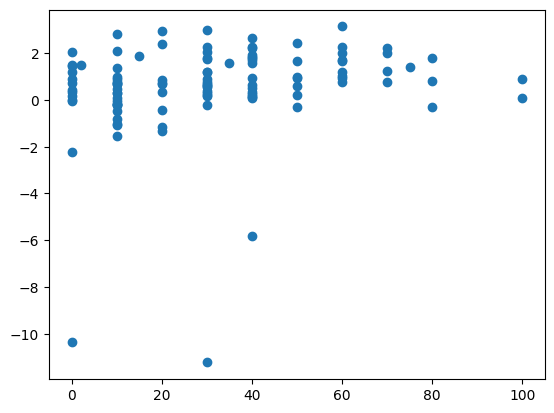

In [3]:
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

samplingRate = 8

data = {
    "Effort": [],
    "Skewness": []
}

# Browse the wristband EDA data trial by trial
for participantId in fullData:
    if participantId != "tracks":
        for session in fullData[participantId]:
            if session != "participant_occupation":
                currentData = fullData[participantId][session]
                psEDA = currentData["wristband"]["EDA"]
                for listening in currentData["post_questionnaires"]:
                    if listening["spotify_id"] is not None:
                        beginning = listening["music_beginning"]
                        end = listening["music_end"] - 10
                        
                        # Fetch the EDA values of the current trial
                        edaValues = []
                        for recording in psEDA:
                            if recording["timestamp"] >= beginning and recording["timestamp"] <= end:
                                edaValues.append(recording["value"])
                        
                        # Some EDA data are missing for some trials, in which case "edaValues" contains 0 values
                        if len(edaValues) > 0:
                            
                            # Resample and process the data
                            resampledValues = nk.signal_resample(edaValues, sampling_rate=4, desired_sampling_rate=samplingRate, method="interpolation")
                            signals, info = nk.eda_process(resampledValues, sampling_rate = samplingRate)

                            if "RSME" in listening:
                                data["Effort"].append(listening["RSME"])
                                data["Skewness"].append(stats.skew(signals["EDA_Phasic"]))

x = data["Effort"]
y = data["Skewness"]

# Compute Spearman correlation
res = stats.spearmanr(x, y)
print("Spearman")
print("rho:", res.statistic)
print("p-value:", res.pvalue)

# Pearson
res = stats.pearsonr(x, y)
print("Pearson")
print("rho:", res.statistic)
print("p-value:", res.pvalue)

# plot it
plt.scatter(x, y)
plt.show()
